# In this notebook, we have the code to test a GAN for the multi minst data

In [13]:
import torch
import torch.optim as optim
from dataloaders import get_mnist_dataloaders, get_multi_mnist_dataloaders
from models import Generator, Discriminator
from training import Trainer
from torch.utils.data import Dataset
import h5py
import numpy as np
from torchvision.utils import make_grid
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [14]:
# Load models
generator = torch.load('wgan-gp/mnist_models/gen_mnist_model_epoch_200.pt',map_location='cpu')
discriminator = torch.load('wgan-gp/mnist_models/dis_mnist_model_epoch_200.pt',map_location='cpu')
img_size = (32, 32, 1)

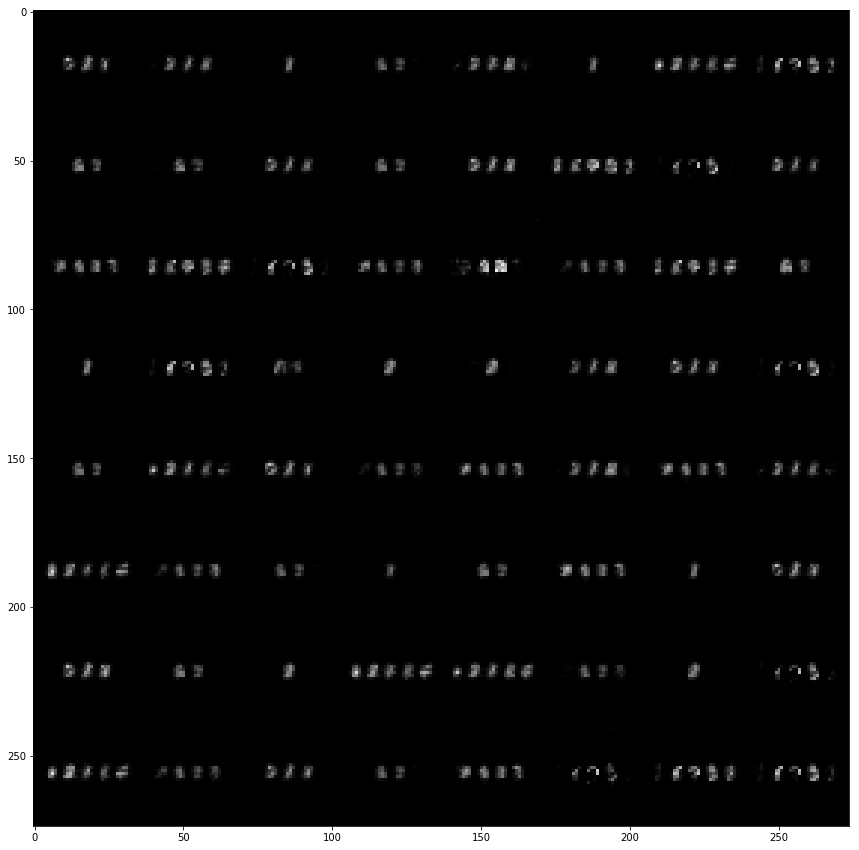

In [15]:
fixed_latents = Variable(generator.sample_latent(64))

# Generate batch of images and convert to grid
img_grid = make_grid(generator(fixed_latents).cpu().data)
# Convert to numpy and transpose axes to fit imageio convention
# i.e. (width, height, channels)
img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))

plt.figure(figsize=(15,15))
plt.imshow(img_grid)
plt.show()